In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

Días      Área  PY_VC_PCA  Valor_Proyecto
#                                                 
1    0.199969 -0.224328  -0.670771       -0.563421
2    0.199969 -0.224328  -0.670771       -0.545120
3    0.199969 -0.222966  -0.670771       -0.544601
4    0.199969 -0.222966  -0.670771       -0.532932
5    1.478731 -0.182279  -0.670771       -0.532623
..        ...       ...        ...             ...
121 -0.699160 -0.219754  -1.883419       -0.617652
122 -0.659199 -0.223679  -1.883419       -0.604545
123 -0.579276 -0.224410  -1.883419       -0.584883
124 -0.898967 -0.074911  -1.932311       -0.488695
125  0.080085 -0.203695  -0.670771        1.333930

[115 rows x 4 columns]

In [ ]:
PY_DATOS_REALES_EST_SA.describe()

Días        Área   PY_VC_PCA  Valor_Proyecto
count  115.000000  115.000000  115.000000      115.000000
mean    -0.082193   -0.098454   -0.089025       -0.097465
std      0.780387    0.605987    1.861373        0.706249
min     -0.918948   -0.224417   -1.932311       -0.682176
25%     -0.669189   -0.224096   -1.883419       -0.587202
50%     -0.359489   -0.222363   -0.670771       -0.410561
75%      0.219950   -0.203633    0.739387        0.150954
max      3.576699    4.300396    3.524117        2.571424

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Usar Huber como pérdida y agregar Huber Loss como métrica
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss=tf.keras.losses.Huber(), #----------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #----------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,   #---------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'learning_rate': (0.0001, 0.1)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=2, n_iter=20) #---------------20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |
-------------------------------------------------------------
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7700 - loss: 0.8590 - mae: 1.1733 - mse: 2.3938 - pearson_correlation: 4.0429e-16 - r2_keras: -278.8247 - rmse: 1.4557 - sae: 4442.2979 - sse: 8679.8135
Epoch 1: val_loss improved from inf to 0.34684, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - huber_loss: 0.6695 - loss: 0.7979 - mae: 1.0966 - mse: 2.2184 - pearson_correlation: 3.9562e-16 - r2_keras: -238.6929 - rmse: 1.4853 - sae: 3223.5120 - sse: 6409.9126 - val_huber_loss: 0.2577 - val_loss: 0.3468 - val_mae: 0.6303 - val_mse: 0.5980 - val_pearson_correlation: 2.8483e-16 - val_r2_keras: -23.7651 - val_rmse: 0.8104 - val_sae: 353.2481 - val_sse: 347.4076 - learning_rate: 0.0375
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - huber_loss: 0.2174 - loss: 0.3065 - mae: 0.5357 - mse: 0.4683 - pearson_correlation: -4.9740e-16 - r2_keras: -99.6105 - rmse: 0.8729 - sae: 2821.0767 - sse: 3120.8125
Epoch 2: val_loss did not improve from 0.34684
2/2 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4488 - loss: 0.4727 - mae: 0.7404 - mse: 2.3886 - pearson_correlation: -4.0218e-16 - r2_keras: -452.9828 - rmse: 1.8542 - sae: 4139.3491 - sse: 14081.9805
Epoch 1: val_loss improved from inf to 0.28113, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - huber_loss: 0.4804 - loss: 0.4919 - mae: 0.7549 - mse: 2.3442 - pearson_correlation: -2.0020e-16 - r2_keras: -365.5810 - rmse: 1.8008 - sae: 3023.0134 - sse: 10137.8379 - val_huber_loss: 0.2573 - val_loss: 0.2811 - val_mae: 0.6306 - val_mse: 0.5323 - val_pearson_correlation: -4.7091e-17 - val_r2_keras: -36.3838 - val_rmse: 0.9957 - val_sae: 426.5493 - val_sse: 524.4238 - learning_rate: 0.0287
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.3257 - loss: 0.3496 - mae: 0.5592 - mse: 1.6175 - pearson_correlation: 4.3679e-16 - r2_keras: -316.9164 - rmse: 1.5516 - sae: 3423.0171 - sse: 9861.3672
Epoch 2: val_loss improved from 0.28113 to 0.24194, sav

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.1376 - loss: 1.1578 - mae: 1.5855 - mse: 3.7307 - pearson_correlation: 3.8686e-16 - r2_keras: -373.2920 - rmse: 1.6836 - sae: 5524.0547 - sse: 11610.0684
Epoch 1: val_loss improved from inf to 0.38645, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - huber_loss: 1.1089 - loss: 1.1404 - mae: 1.5627 - mse: 3.7242 - pearson_correlation: 2.1468e-16 - r2_keras: -322.4336 - rmse: 1.7295 - sae: 4078.3625 - sse: 8606.9609 - val_huber_loss: 0.3662 - val_loss: 0.3865 - val_mae: 0.7143 - val_mse: 1.0354 - val_pearson_correlation: 0.0000e+00 - val_r2_keras: -35.2740 - val_rmse: 0.9808 - val_sae: 361.9647 - val_sse: 508.8560 - learning_rate: 0.0023
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 1.1080 - loss: 1.1282 - mae: 1.5525 - mse: 3.6041 - pearson_correlation: 5.8370e-18 - r2_keras: -359.6870 - rmse: 1.6527 - sae: 5404.2231 - sse: 11188.0605
Epoch 2: val_loss did not improve from 0.38645
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4994 - loss: 0.5710 - mae: 0.8956 - mse: 1.7934 - pearson_correlation: 6.3839e-16 - r2_keras: -270.2909 - rmse: 1.4333 - sae: 3735.1780 - sse: 8415.1035
Epoch 1: val_loss improved from inf to 0.34608, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 913ms/step - huber_loss: 0.5471 - loss: 0.6000 - mae: 0.9258 - mse: 1.9495 - pearson_correlation: 4.3707e-16 - r2_keras: -234.5057 - rmse: 1.4776 - sae: 2756.5945 - sse: 6251.0581 - val_huber_loss: 0.2745 - val_loss: 0.3461 - val_mae: 0.6384 - val_mse: 0.6691 - val_pearson_correlation: 7.8508e-17 - val_r2_keras: -22.4862 - val_rmse: 0.7892 - val_sae: 323.4807 - val_sse: 329.4666 - learning_rate: 0.0037
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.3348 - loss: 0.4064 - mae: 0.6242 - mse: 1.2024 - pearson_correlation: -4.1922e-16 - r2_keras: -214.5686 - rmse: 1.2777 - sae: 3229.6938 - sse: 6686.6689
Epoch 2: val_loss improved from 0.34608 to 0.34176, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.0683 - loss: 1.0909 - mae: 1.5388 - mse: 3.1344 - pearson_correlation: 8.9336e-17 - r2_keras: -306.5794 - rmse: 1.5262 - sae: 5194.9795 - sse: 9540.7285
Epoch 1: val_loss improved from inf to 0.29817, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - huber_loss: 0.8675 - loss: 0.9687 - mae: 1.4002 - mse: 2.7074 - pearson_correlation: -2.7808e-17 - r2_keras: -243.9868 - rmse: 1.4637 - sae: 3751.5276 - sse: 6828.9106 - val_huber_loss: 0.2755 - val_loss: 0.2982 - val_mae: 0.6132 - val_mse: 0.7092 - val_pearson_correlation: 7.4448e-17 - val_r2_keras: -24.0488 - val_rmse: 0.8150 - val_sae: 302.3776 - val_sse: 351.3869 - learning_rate: 0.0594
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.5531 - loss: 0.5758 - mae: 0.9539 - mse: 1.3027 - pearson_correlation: -1.8471e-17 - r2_keras: -141.2081 - rmse: 1.0378 - sae: 3391.1785 - sse: 4411.1187
Epoch 2: val_loss improved from 0.29817 to 0.26142, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5851 - loss: 0.6082 - mae: 0.9425 - mse: 1.6399 - pearson_correlation: -1.8303e-17 - r2_keras: -221.5600 - rmse: 1.2982 - sae: 3947.6533 - sse: 6903.5332
Epoch 1: val_loss improved from inf to 0.39605, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - huber_loss: 0.5642 - loss: 0.5955 - mae: 0.9363 - mse: 1.5738 - pearson_correlation: -1.0037e-16 - r2_keras: -177.9203 - rmse: 1.2558 - sae: 2866.1667 - sse: 4960.6729 - val_huber_loss: 0.3730 - val_loss: 0.3960 - val_mae: 0.7717 - val_mse: 0.8612 - val_pearson_correlation: 1.2419e-16 - val_r2_keras: -32.5307 - val_rmse: 0.9430 - val_sae: 405.0162 - val_sse: 470.3730 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.5834 - loss: 0.6064 - mae: 0.9407 - mse: 1.6345 - pearson_correlation: -1.1976e-16 - r2_keras: -221.0050 - rmse: 1.2966 - sae: 3941.1685 - sse: 6886.3184
Epoch 2: val_loss did not improve from 0.39605
2/2 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5828 - loss: 0.6302 - mae: 1.0344 - mse: 1.6610 - pearson_correlation: -9.2370e-17 - r2_keras: -186.0323 - rmse: 1.1901 - sae: 3724.6953 - sse: 5801.5093
Epoch 1: val_loss improved from inf to 0.24998, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - huber_loss: 0.7484 - loss: 0.7311 - mae: 1.1294 - mse: 2.0944 - pearson_correlation: -1.8535e-16 - r2_keras: -223.3085 - rmse: 1.4983 - sae: 2928.9990 - sse: 5036.2222 - val_huber_loss: 0.2022 - val_loss: 0.2500 - val_mae: 0.5291 - val_mse: 0.4719 - val_pearson_correlation: 1.6885e-16 - val_r2_keras: -22.7034 - val_rmse: 0.7928 - val_sae: 323.8316 - val_sse: 332.5139 - learning_rate: 0.0928
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2401 - loss: 0.2879 - mae: 0.5439 - mse: 0.5488 - pearson_correlation: -1.6777e-16 - r2_keras: -94.6950 - rmse: 0.8513 - sae: 2559.1453 - sse: 2968.3384
Epoch 2: val_loss did not improve from 0.24998
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.3029 - loss: 0.3279 - mae: 0.6834 - mse: 0.7342 - pearson_correlation: -6.2927e-16 - r2_keras: -90.3844 - rmse: 0.8319 - sae: 2787.5098 - sse: 2834.6294
Epoch 1: val_loss improved from inf to 0.30111, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - huber_loss: 0.2597 - loss: 0.3016 - mae: 0.6458 - mse: 0.6556 - pearson_correlation: -4.4616e-16 - r2_keras: -83.7138 - rmse: 0.8991 - sae: 2067.4631 - sse: 2168.8210 - val_huber_loss: 0.2761 - val_loss: 0.3011 - val_mae: 0.6361 - val_mse: 0.6821 - val_pearson_correlation: 5.6258e-17 - val_r2_keras: -24.3271 - val_rmse: 0.8195 - val_sae: 322.4304 - val_sse: 355.2920 - learning_rate: 0.0657
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.3955 - loss: 0.4205 - mae: 0.8084 - mse: 0.8378 - pearson_correlation: -1.3124e-16 - r2_keras: -107.5660 - rmse: 0.9067 - sae: 3001.1660 - sse: 3367.5811
Epoch 2: val_loss improved from 0.30111 to 0.22471, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.8006 - loss: 1.8353 - mae: 2.2775 - mse: 7.6255 - pearson_correlation: 1.8105e-16 - r2_keras: -841.9276 - rmse: 2.5265 - sae: 8480.0000 - sse: 26146.5586
Epoch 1: val_loss improved from inf to 0.27056, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - huber_loss: 1.4506 - loss: 1.6223 - mae: 2.0478 - mse: 6.6202 - pearson_correlation: 9.3969e-17 - r2_keras: -612.4614 - rmse: 2.1912 - sae: 5930.5483 - sse: 18035.2500 - val_huber_loss: 0.2358 - val_loss: 0.2706 - val_mae: 0.5373 - val_mse: 0.6014 - val_pearson_correlation: -1.7539e-16 - val_r2_keras: -22.8630 - val_rmse: 0.7955 - val_sae: 291.9883 - val_sse: 334.7531 - learning_rate: 0.0318
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.5188 - loss: 0.5536 - mae: 0.9055 - mse: 2.0308 - pearson_correlation: 5.9330e-17 - r2_keras: -233.1636 - rmse: 1.3317 - sae: 3513.7683 - sse: 7263.4619
Epoch 2: val_loss improved from 0.27056 to 0.25146, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6406 - loss: 0.6782 - mae: 1.0884 - mse: 1.8961 - pearson_correlation: -2.9998e-17 - r2_keras: -191.0585 - rmse: 1.2060 - sae: 3966.3838 - sse: 5957.4131
Epoch 1: val_loss improved from inf to 0.28267, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - huber_loss: 0.5543 - loss: 0.6256 - mae: 1.0239 - mse: 1.6791 - pearson_correlation: -3.7637e-17 - r2_keras: -145.5000 - rmse: 1.1074 - sae: 2837.3076 - sse: 4188.1572 - val_huber_loss: 0.2451 - val_loss: 0.2827 - val_mae: 0.5727 - val_mse: 0.6004 - val_pearson_correlation: -6.9091e-17 - val_r2_keras: -22.3831 - val_rmse: 0.7875 - val_sae: 311.3388 - val_sse: 328.0213 - learning_rate: 0.0129
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.3100 - loss: 0.3476 - mae: 0.6832 - mse: 0.8102 - pearson_correlation: -1.1585e-16 - r2_keras: -97.7768 - rmse: 0.8649 - sae: 2713.8789 - sse: 3063.9319
Epoch 2: val_loss improved from 0.28267 to 0.27728, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7842 - loss: 0.8196 - mae: 1.1273 - mse: 2.6638 - pearson_correlation: -2.4654e-16 - r2_keras: -290.2688 - rmse: 1.4852 - sae: 4237.0962 - sse: 9034.7930
Epoch 1: val_loss improved from inf to 0.28520, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - huber_loss: 0.6908 - loss: 0.7628 - mae: 1.0768 - mse: 2.3821 - pearson_correlation: -1.5296e-16 - r2_keras: -220.4624 - rmse: 1.3590 - sae: 3061.1819 - sse: 6343.2285 - val_huber_loss: 0.2497 - val_loss: 0.2852 - val_mae: 0.6107 - val_mse: 0.5804 - val_pearson_correlation: 3.0779e-16 - val_r2_keras: -24.8103 - val_rmse: 0.8273 - val_sae: 358.1109 - val_sse: 362.0696 - learning_rate: 0.0608
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - huber_loss: 0.2967 - loss: 0.3321 - mae: 0.6820 - mse: 0.6269 - pearson_correlation: -2.9467e-18 - r2_keras: -100.9753 - rmse: 0.8788 - sae: 2857.4045 - sse: 3163.1460
Epoch 2: val_loss did not improve from 0.28520
2/2 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8181 - loss: 0.8527 - mae: 1.2350 - mse: 2.6500 - pearson_correlation: -1.3640e-16 - r2_keras: -382.3705 - rmse: 1.7039 - sae: 5378.1626 - sse: 11891.6738
Epoch 1: val_loss improved from inf to 0.24535, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - huber_loss: 0.9117 - loss: 0.9098 - mae: 1.3003 - mse: 2.7486 - pearson_correlation: -1.5409e-16 - r2_keras: -326.3245 - rmse: 1.7341 - sae: 3982.0315 - sse: 8769.3447 - val_huber_loss: 0.2100 - val_loss: 0.2453 - val_mae: 0.4996 - val_mse: 0.5426 - val_pearson_correlation: -2.3684e-16 - val_r2_keras: -23.6837 - val_rmse: 0.8091 - val_sae: 298.0934 - val_sse: 346.2654 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.2310 - loss: 0.2663 - mae: 0.4979 - mse: 0.6330 - pearson_correlation: -5.8162e-16 - r2_keras: -135.6642 - rmse: 1.0173 - sae: 2725.5688 - sse: 4239.1533
Epoch 2: val_loss did not improve from 0.24535
2/2 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7796 - loss: 0.8159 - mae: 1.1493 - mse: 2.0842 - pearson_correlation: 9.3688e-16 - r2_keras: -295.1950 - rmse: 1.4977 - sae: 4699.2979 - sse: 9187.5986
Epoch 1: val_loss improved from inf to 0.22977, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - huber_loss: 0.8009 - loss: 0.8290 - mae: 1.1718 - mse: 2.1376 - pearson_correlation: 6.3435e-16 - r2_keras: -268.2135 - rmse: 1.5967 - sae: 3518.3984 - sse: 6966.6982 - val_huber_loss: 0.1921 - val_loss: 0.2298 - val_mae: 0.4615 - val_mse: 0.4771 - val_pearson_correlation: 2.2348e-16 - val_r2_keras: -24.3676 - val_rmse: 0.8202 - val_sae: 307.6284 - val_sse: 355.8601 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.1936 - loss: 0.2313 - mae: 0.4895 - mse: 0.4438 - pearson_correlation: -9.8844e-17 - r2_keras: -95.2237 - rmse: 0.8536 - sae: 2736.6482 - sse: 2984.7378
Epoch 2: val_loss improved from 0.22977 to 0.21687, saving m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8792 - loss: 0.9136 - mae: 1.3188 - mse: 2.6985 - pearson_correlation: 2.4319e-16 - r2_keras: -349.9147 - rmse: 1.6302 - sae: 5290.7168 - sse: 10884.9346
Epoch 1: val_loss improved from inf to 0.17952, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - huber_loss: 0.9830 - loss: 0.9769 - mae: 1.3816 - mse: 2.9531 - pearson_correlation: 1.4748e-16 - r2_keras: -339.7794 - rmse: 1.8167 - sae: 3960.6951 - sse: 8509.8154 - val_huber_loss: 0.1442 - val_loss: 0.1795 - val_mae: 0.3831 - val_mse: 0.3355 - val_pearson_correlation: -8.7588e-17 - val_r2_keras: -28.1409 - val_rmse: 0.8791 - val_sae: 326.2622 - val_sse: 408.7914 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.5780 - loss: 0.6133 - mae: 0.9588 - mse: 1.5919 - pearson_correlation: 1.7390e-16 - r2_keras: -319.4021 - rmse: 1.5577 - sae: 4978.3159 - sse: 9938.4727
Epoch 2: val_loss did not improve from 0.17952
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6996 - loss: 0.7349 - mae: 1.0886 - mse: 2.3802 - pearson_correlation: -1.0784e-16 - r2_keras: -400.5531 - rmse: 1.7438 - sae: 5457.2949 - sse: 12455.6738
Epoch 1: val_loss improved from inf to 0.28064, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - huber_loss: 0.7319 - loss: 0.7546 - mae: 1.1098 - mse: 2.3776 - pearson_correlation: -1.1913e-17 - r2_keras: -326.1563 - rmse: 1.7071 - sae: 3976.5276 - sse: 9001.1826 - val_huber_loss: 0.2453 - val_loss: 0.2806 - val_mae: 0.5337 - val_mse: 0.6267 - val_pearson_correlation: 2.1676e-16 - val_r2_keras: -25.3053 - val_rmse: 0.8352 - val_sae: 300.3358 - val_sse: 369.0134 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.6957 - loss: 0.7311 - mae: 1.0831 - mse: 2.3624 - pearson_correlation: 6.9059e-17 - r2_keras: -397.7568 - rmse: 1.7377 - sae: 5434.3994 - sse: 12368.9375
Epoch 2: val_loss did not improve from 0.28064
2/2 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7929 - loss: 0.8264 - mae: 1.2440 - mse: 1.8470 - pearson_correlation: -3.9647e-16 - r2_keras: -196.1716 - rmse: 1.2220 - sae: 4153.5161 - sse: 6116.0156
Epoch 1: val_loss improved from inf to 0.24186, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - huber_loss: 0.8737 - loss: 0.8757 - mae: 1.2833 - mse: 2.1061 - pearson_correlation: -4.5228e-16 - r2_keras: -217.5694 - rmse: 1.4738 - sae: 3199.3640 - sse: 5099.2842 - val_huber_loss: 0.2076 - val_loss: 0.2419 - val_mae: 0.5144 - val_mse: 0.5100 - val_pearson_correlation: -2.1168e-16 - val_r2_keras: -22.8175 - val_rmse: 0.7947 - val_sae: 308.3141 - val_sse: 334.1143 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.1344 - loss: 0.1687 - mae: 0.3522 - mse: 0.2852 - pearson_correlation: 3.0872e-16 - r2_keras: -106.7102 - rmse: 0.9032 - sae: 2701.6655 - sse: 3341.0356
Epoch 2: val_loss improved from 0.24186 to 0.21844, savin

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9555 - loss: 0.9909 - mae: 1.3971 - mse: 2.9351 - pearson_correlation: -2.6968e-16 - r2_keras: -339.7262 - rmse: 1.6063 - sae: 5193.3384 - sse: 10568.9004
Epoch 1: val_loss improved from inf to 0.34495, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 505ms/step - huber_loss: 1.0271 - loss: 1.0348 - mae: 1.4331 - mse: 3.2015 - pearson_correlation: -2.2954e-16 - r2_keras: -353.3244 - rmse: 1.8673 - sae: 3934.7576 - sse: 8537.6846 - val_huber_loss: 0.3078 - val_loss: 0.3450 - val_mae: 0.6284 - val_mse: 0.8262 - val_pearson_correlation: 9.4753e-18 - val_r2_keras: -28.7371 - val_rmse: 0.8880 - val_sae: 324.0795 - val_sse: 417.1550 - learning_rate: 0.1000
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2527 - loss: 0.2899 - mae: 0.5688 - mse: 0.5901 - pearson_correlation: -3.9921e-16 - r2_keras: -114.4648 - rmse: 0.9351 - sae: 2780.1873 - sse: 3581.5735
Epoch 2: val_loss improved from 0.34495 to 0.32154, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7539 - loss: 0.7792 - mae: 1.2108 - mse: 1.9382 - pearson_correlation: 1.6021e-16 - r2_keras: -247.6095 - rmse: 1.3721 - sae: 4591.9292 - sse: 7711.5566
Epoch 1: val_loss improved from inf to 0.19297, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - huber_loss: 0.6199 - loss: 0.6977 - mae: 1.1042 - mse: 1.7063 - pearson_correlation: 2.4756e-16 - r2_keras: -202.6074 - rmse: 1.3493 - sae: 3312.7830 - sse: 5585.2280 - val_huber_loss: 0.1676 - val_loss: 0.1930 - val_mae: 0.4643 - val_mse: 0.3955 - val_pearson_correlation: 1.6552e-16 - val_r2_keras: -24.2229 - val_rmse: 0.8178 - val_sae: 321.3003 - val_sse: 353.8292 - learning_rate: 0.0977
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.2003 - loss: 0.2257 - mae: 0.5542 - mse: 0.4133 - pearson_correlation: 2.2744e-16 - r2_keras: -99.9037 - rmse: 0.8741 - sae: 2748.5815 - sse: 3129.9062
Epoch 2: val_loss improved from 0.19297 to 0.18741, saving mo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6173 - loss: 0.6390 - mae: 1.0366 - mse: 2.0530 - pearson_correlation: -3.0725e-16 - r2_keras: -290.0604 - rmse: 1.4846 - sae: 4627.8027 - sse: 9028.3301
Epoch 1: val_loss improved from inf to 0.23723, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - huber_loss: 0.6406 - loss: 0.6532 - mae: 1.0561 - mse: 1.9576 - pearson_correlation: -2.3323e-16 - r2_keras: -230.1204 - rmse: 1.4198 - sae: 3364.6753 - sse: 6453.8379 - val_huber_loss: 0.2153 - val_loss: 0.2372 - val_mae: 0.5461 - val_mse: 0.5043 - val_pearson_correlation: -4.0649e-16 - val_r2_keras: -29.4407 - val_rmse: 0.8985 - val_sae: 349.9995 - val_sse: 427.0259 - learning_rate: 0.0522
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.7233 - loss: 0.7452 - mae: 1.1677 - mse: 2.2080 - pearson_correlation: 3.0325e-16 - r2_keras: -341.0172 - rmse: 1.6094 - sae: 5311.2158 - sse: 10608.9463
Epoch 2: val_loss improved from 0.23723 to 0.21963, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.9406 - loss: 0.9781 - mae: 1.3233 - mse: 3.3521 - pearson_correlation: 3.2514e-16 - r2_keras: -561.8450 - rmse: 2.0646 - sae: 6167.7744 - sse: 17458.7480
Epoch 1: val_loss improved from inf to 0.30010, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - huber_loss: 0.9404 - loss: 0.9780 - mae: 1.3204 - mse: 3.3049 - pearson_correlation: 7.2168e-17 - r2_keras: -447.6839 - rmse: 1.9816 - sae: 4468.9727 - sse: 12500.7822 - val_huber_loss: 0.2626 - val_loss: 0.3001 - val_mae: 0.5654 - val_mse: 0.5982 - val_pearson_correlation: -7.2979e-16 - val_r2_keras: -30.3377 - val_rmse: 0.9116 - val_sae: 341.9490 - val_sse: 439.6089 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - huber_loss: 0.9352 - loss: 0.9727 - mae: 1.3182 - mse: 3.3238 - pearson_correlation: 1.5311e-17 - r2_keras: -558.1017 - rmse: 2.0577 - sae: 6148.1724 - sse: 17342.6367
Epoch 2: val_loss did not improve from 0.30010
2/2 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.6064 - loss: 0.6402 - mae: 0.9871 - mse: 1.5698 - pearson_correlation: -7.2867e-17 - r2_keras: -200.4515 - rmse: 1.2351 - sae: 4127.7783 - sse: 6248.7739
Epoch 1: val_loss improved from inf to 0.33689, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - huber_loss: 0.6155 - loss: 0.6457 - mae: 0.9963 - mse: 1.5835 - pearson_correlation: 1.9408e-18 - r2_keras: -158.8202 - rmse: 1.1802 - sae: 2980.9685 - sse: 4465.1904 - val_huber_loss: 0.3031 - val_loss: 0.3369 - val_mae: 0.6826 - val_mse: 0.7161 - val_pearson_correlation: 2.3816e-17 - val_r2_keras: -23.0806 - val_rmse: 0.7991 - val_sae: 335.7332 - val_sse: 337.8055 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.6024 - loss: 0.6362 - mae: 0.9829 - mse: 1.5552 - pearson_correlation: 1.7783e-16 - r2_keras: -199.3339 - rmse: 1.2317 - sae: 4119.8779 - sse: 6214.1079
Epoch 2: val_loss did not improve from 0.33689
2/2 ━━━━

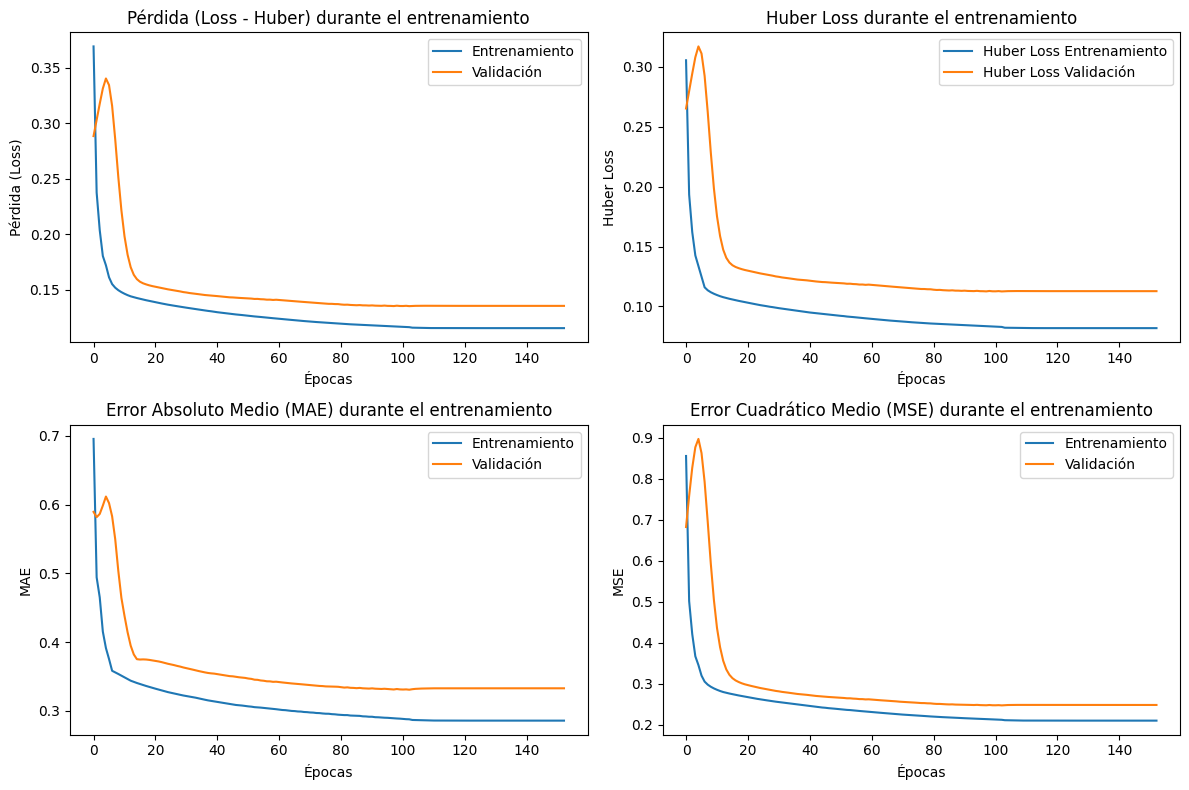

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


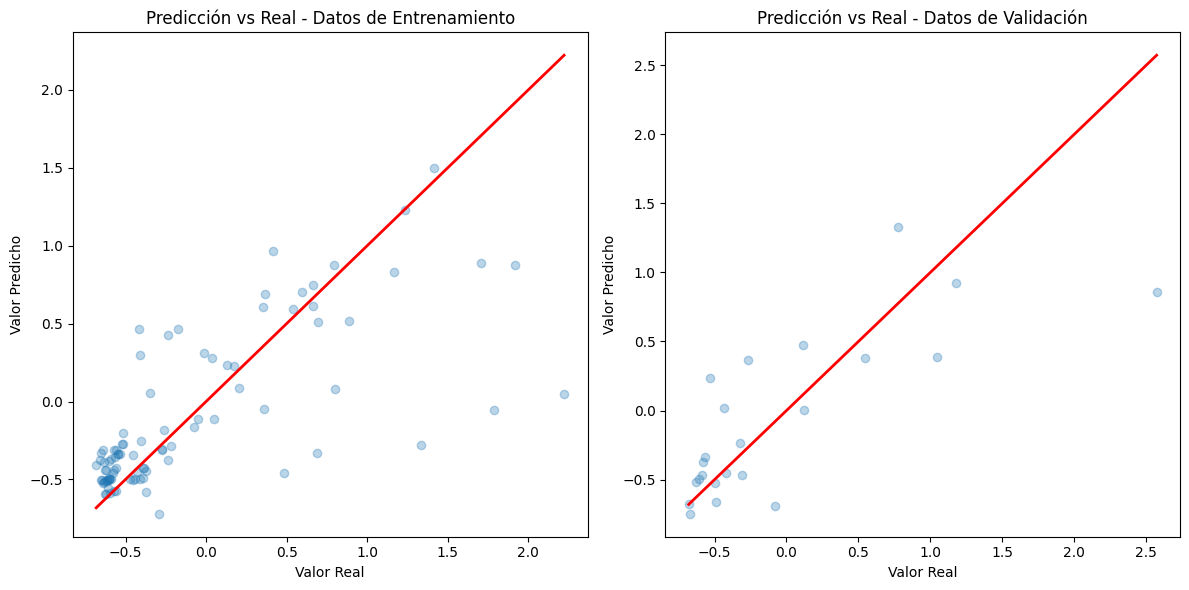


Métricas de entrenamiento:
MSE: 0.21778867836136956
RMSE: 0.46667834571722905
MAE: 0.27805005446494446
R^2: 0.5317003951294923
Correlación de Pearson: -3.880427159553404e-16
Correlación de Spearman: 0.7520373603248978
SSE: 5990.609032454245
SAE: 5145.094731976175
Media del error: 0.012290065776886164
Desviación estándar del error: 0.8412039726035614
Huber Loss (Entrenamiento): 0.08185034245252609

Métricas de validación:
MSE: 0.24726995225647178
RMSE: 0.4972624581209321
MAE: 0.3308984152808754
R^2: 0.5945847179926115
Correlación de Pearson: 1.7206456345011171e-16
Correlación de Spearman: 0.7598814229249011
SSE: 497.52186620160325
SAE: 371.8185106259325
Media del error: 0.015663198848728112
Desviación estándar del error: 0.9696647283349428
Huber Loss (Validación): 0.11273304373025894
El punto de convergencia (mejor epoch): 103


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss - Huber) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


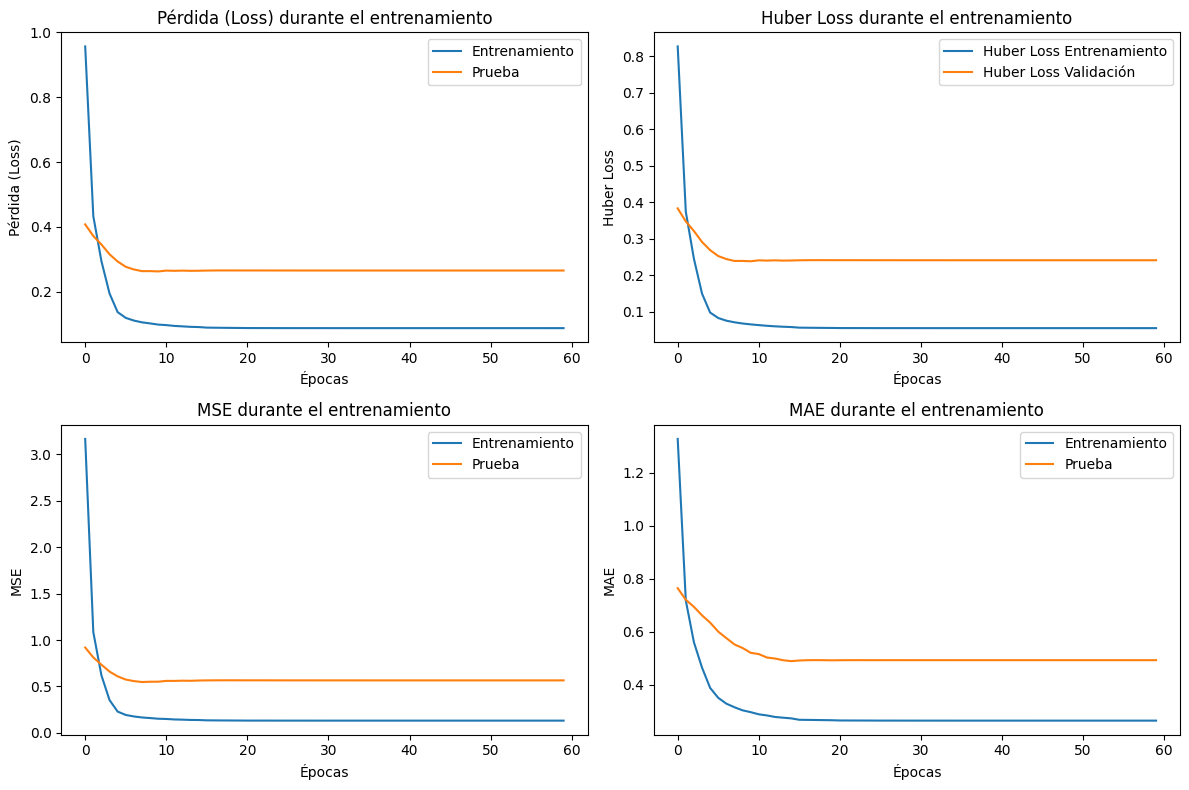

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


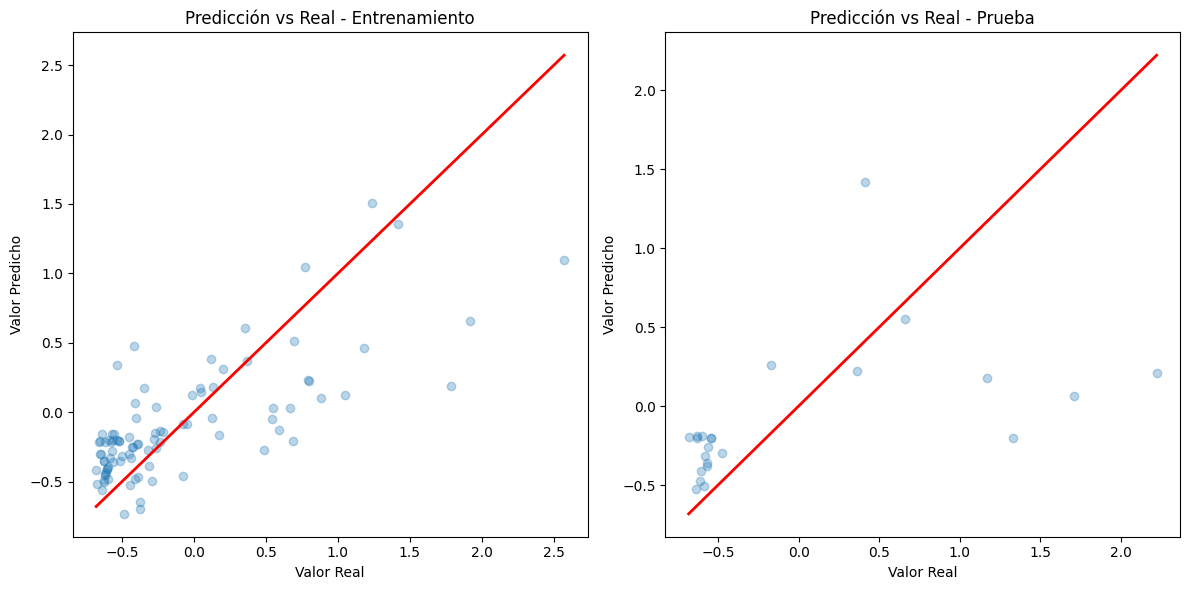

Simulación de cross_val_score (MSE): 0.27997224306705804 ± 0.15191071941529283
Simulación de cross_val_score (RMSE): 0.5110505399824786 ± 0.137111591963171
Simulación de cross_val_score (MAE): 0.3678306485094163 ± 0.09177065222786947
SSE promedio: 406.1705695311231
SAE promedio: 339.8285437925151
R^2 promedio: 0.4117755198668032, Desviación estándar: 0.24130140902526817
Correlación de Pearson promedio: 5.837486948859101e-17, Desviación estándar: 5.7360981466872e-17
Correlación de Spearman promedio: 0.600655155556745, Desviación estándar: 0.08118421752309554
Huber Loss promedio: 0.09375020042061806, Desviación estándar: 0.02207157957238043
El punto de convergencia (mejor epoch): 10


In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_1 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Access units_2 from best_params
        LeakyReLU(alpha=0.1),  # Cambiar ELU por LeakyReLU
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    model.compile(optimizer=tf.keras.optimizers.SGD(best_params['learning_rate']),#------------------------------------
                  loss=tf.keras.losses.Huber(),                      #---------------------
                  metrics=['mae', 'mse', sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000, #--------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['huber_loss'], label='Huber Loss Entrenamiento')
plt.plot(history.history['val_huber_loss'], label='Huber Loss Validación')
plt.title('Huber Loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Huber Loss')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")